In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/diego/local_repos/AGEC652_2024/AGEC652_2024/slides/lecture_6_3"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| include: false
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Pkg.add("JuMP")
# Pkg.add("Ipopt")
# Pkg.add("Statistics")
# Pkg.add("Plots")
# Pkg.add("ForwardDiff")
# Pkg.add("LinearAlgebra")
# Pkg.add("LaTeXStrings")
# Pkg.add("GLM")
# Pkg.add("DataFrames")
# Pkg.add("Distributions")

  Activating project at `~/local_repos/AGEC652_2024/AGEC652_2024/slides/lecture_6_3`


In [3]:
β_b = [-2.5, -2.0,  0.4,  0.0,  0.3, -0.2, -0.3]
β_t = [-1.4, -2.0,  0.0,  0.9,  0.5, -0.1, -0.2] 

7-element Vector{Float64}:
 -1.4
 -2.0
  0.0
  0.9
  0.5
 -0.1
 -0.2

In [4]:
N_survey = 200 # Individuals surveyed per city
N_nr_cities = 30 # Non-rail cities surveyed

30

In [5]:
using Random, Distributions, Statistics
Random.seed!(652)
density_nr = rand(Uniform(1, 8), N_nr_cities); # Thousands of people per square mile

In [6]:
busroutes_nr = 5 .+ density_nr .* 6 .+ rand(Uniform(-3, 3), N_nr_cities) # 6 x density plus random variation
busroutes_nr = round.(busroutes_nr, digits = 0); # Make it an integer

In [7]:
price_nr = busroutes_nr .* 20 .+ rand(Uniform(-50, 50), N_nr_cities) ./ 100; # 10 x routs plus random variation
price_nr = price_nr ./ 100; # Re-scale to hundreds of dollars

In [8]:
using DataFrames
cities_nr = DataFrame(
  city = ["nr_$(i)" for i in 1:N_nr_cities], # Create an index
  price = price_nr,
  busroutes = busroutes_nr, 
  trainstops = zeros(N_nr_cities), # No trains
  density = density_nr
);
println(cities_nr[1:5,:]) # Look at first 5 rows

5×5 DataFrame
 Row │ city    price    busroutes  trainstops  density 
     │ String  Float64  Float64    Float64     Float64 
─────┼─────────────────────────────────────────────────
   1 │ nr_1    7.20091       36.0         0.0  5.30334
   2 │ nr_2    9.80092       49.0         0.0  7.70467
   3 │ nr_3    6.39744       32.0         0.0  4.35255
   4 │ nr_4    8.80393       44.0         0.0  6.29315
   5 │ nr_5    5.39916       27.0         0.0  4.07286


In [9]:
homeown_nr = rand(Bernoulli(0.75), N_survey * N_nr_cities);

In [10]:
hhsize_nr = rand(Poisson(3.0), N_survey * N_nr_cities);

In [11]:
survey_nr = DataFrame(
  city = repeat(["nr_$(i)" for i in 1:N_nr_cities], N_survey), # Create an index
  hhsize = hhsize_nr,
  homeown = homeown_nr
);

In [12]:
data_nr = leftjoin(survey_nr, cities_nr, on = :city);
println(data_nr[1:10,:]) # Look at first 10 rows

10×7 DataFrame
 Row │ city    hhsize  homeown  price     busroutes  trainstops  density  
     │ String  Int64   Bool     Float64?  Float64?   Float64?    Float64? 
─────┼────────────────────────────────────────────────────────────────────
   1 │ nr_1         7    false   7.20091       36.0         0.0   5.30334
   2 │ nr_2         5     true   9.80092       49.0         0.0   7.70467
   3 │ nr_3         4     true   6.39744       32.0         0.0   4.35255
   4 │ nr_4         3    false   8.80393       44.0         0.0   6.29315
   5 │ nr_5         2     true   5.39916       27.0         0.0   4.07286
   6 │ nr_6         3     true   3.59531       18.0         0.0   2.42885
   7 │ nr_7         3    false   3.40168       17.0         0.0   1.87182
   8 │ nr_8         2    false   9.99662       50.0         0.0   7.32123
   9 │ nr_9         5     true   4.40378       22.0         0.0   2.33616
  10 │ nr_10        1     true   7.80017       39.0         0.0   5.5303


In [13]:
data_nr.V_ib = zeros(nrow(data_nr)) # Initialize V_{ib}
data_nr.V_it = zeros(nrow(data_nr)) # Placeholder for V_{it}
for i in 1:nrow(data_nr)
  # Get the corresponding row
  data_row = data_nr[i, [:price, :busroutes, :trainstops, :density, :hhsize, :homeown]]
  # Turn it into a numerical vector (adding the constant 1 in the first element)
  X_i = vcat(1.0, Vector{Float64}(data_row))

  # Calculate and store
  data_nr.V_ib[i] = X_i' * β_b;

end

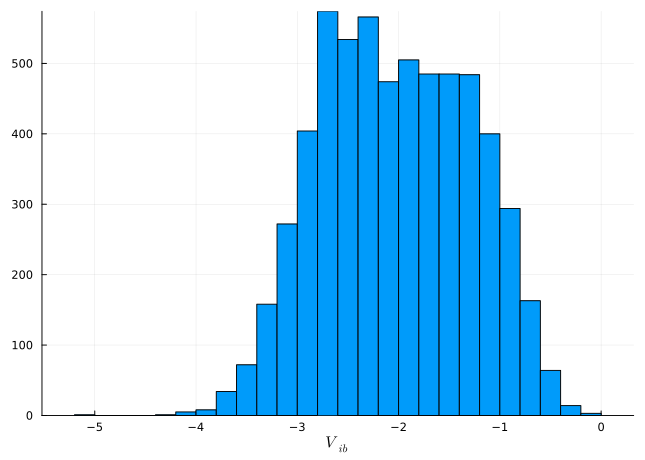

In [14]:
using Plots, LaTeXStrings
histogram(data_nr.V_ib, xlabel=L"V_{ib}", label="")

In [15]:
data_nr.ϵ_ib = rand(Logistic(0.0, 0.8), nrow(data_nr));
data_nr.ϵ_it = rand(Logistic(0.0, 0.8), nrow(data_nr));

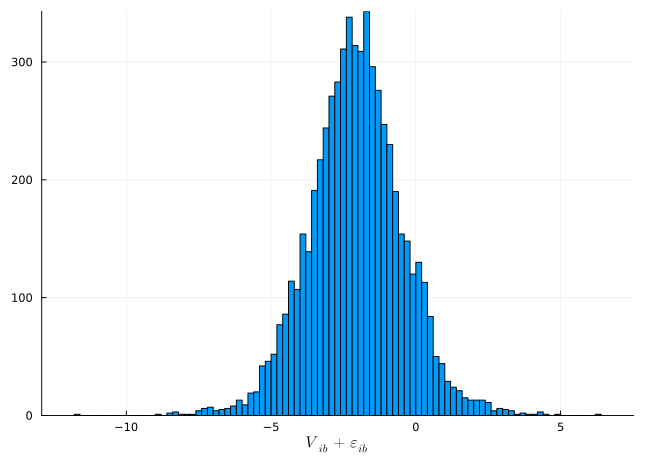

In [16]:
histogram(data_nr.V_ib .+ data_nr.ϵ_ib, xlabel=L"V_{ib} + \epsilon_{ib}", label="")

In [17]:
data_nr.d_ib = (data_nr.V_ib .+ data_nr.ϵ_ib .>= 0.0) 

6000-element BitVector:
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0

In [18]:
sum(data_nr.d_ib)/nrow(data_nr)

0.09833333333333333